In [16]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import welch

%store -r indexes_case1
%store -r indexes_case13
%store -r data
%store -r mill_data

def frequency_features(signal):
    # Assuming 'signal' contains the vibration data
    # Assuming 'nperseg' is the length of each segment
    # Assuming 'noverlap' is the overlap between segments
    
    # Initialize an empty list to store spectral kurtosis values for each segment
    spec_kurtosis_segments = []
    noverlap=90
    nperseg=180
    freq=[]
    psds=[]
    segments=[]

    # Calculate the number of segments
    num_segments = (len(signal) - noverlap) // (nperseg - noverlap)

    # Loop over each segment
    for i in range(num_segments):
        # Extract the current segment
        segment = signal[i * (nperseg - noverlap): i * (nperseg - noverlap) + nperseg]
        #print(i,len(segment))

        # Compute power spectral density using Welch method
        freqs, psd = welch(segment, nperseg=nperseg)

        # Compute kurtosis of the power spectrum
        spec_kurtosis = kurtosis(psd, fisher=False)  # Fisher's definition of kurtosis

        # Append the spectral kurtosis to the list
        spec_kurtosis_segments.append(spec_kurtosis)
        freq.append(freqs)
        psds.append(psd)
        segments.append(segment)


    # Convert the list of spectral kurtosis values into a numpy array
    spec_kurtosis_segments = np.array(spec_kurtosis_segments)
    freq=np.array(freq)
    psds=np.array(psds)
    segments=np.array(segments)

    # Example of feature analysis
    #print("Spectral Kurtosis for each segment:", spec_kurtosis_segments)
    #print(len(spec_kurtosis_segments))

    SK_Mean=np.mean(spec_kurtosis_segments)
    SK_Std=np.std(spec_kurtosis_segments)
    SK_Kurt=kurtosis(spec_kurtosis_segments)
    SK_Skewness=skew(spec_kurtosis_segments)

    return SK_Mean, SK_Std, SK_Kurt,SK_Skewness,spec_kurtosis_segments,freq,psds,segments

def features_extracted(vib_table_case1_run1_array,vib_spindle_case1_run1_array,
                       vib_table_case13_run1_array,vib_spindle_case13_run1_array):

    features_dict={}
    variable_names=['table','spindle']
    cases=['case1','case13']

    # Two vibration arrays for each case
    case_data = {
        'case1': {
            'table': vib_table_case1_run1_array,
            'spindle': vib_spindle_case1_run1_array
        },
        'case13': {
            'table': vib_table_case13_run1_array,
            'spindle': vib_spindle_case13_run1_array
        }
    }

    for case in cases:
        case_results={}
        for variable in variable_names:
            vib_array=case_data[case][variable]
            statistics_results={}

            statistics_results['mean']=np.mean(vib_array)
            statistics_results['std_dev']=np.std(vib_array)
            statistics_results['kurt']=kurtosis(vib_array)
            statistics_results['skewness']=skew(vib_array)
            statistics_results['rms']=np.sqrt(np.mean(vib_array**2))
            statistics_results['peak_to_peak']=np.max(vib_array)-np.min(vib_array)
            statistics_results['crest_factor'] = np.max(np.abs(vib_array)) / statistics_results['rms']
            statistics_results['shape_factor'] = statistics_results['rms']/statistics_results['mean']
            statistics_results['impulse_factor'] = (np.max(np.abs(vib_array)) / statistics_results['mean'])
            statistics_results['margin_factor']=np.max(np.abs(vib_array))//(np.mean(np.sqrt(vib_array)))**2
            statistics_results['energy']=np.sum(vib_array**2)

            SK_Mean, SK_Std, SK_Kurt,SK_Skewness,spec_kurtosis_segments,freq,psds,segments=frequency_features(vib_array)
            statistics_results['SK_Mean']=SK_Mean
            statistics_results['SK_Std']=SK_Std
            statistics_results['SK_Kurt']=SK_Kurt
            statistics_results['SK_Skewness']=SK_Skewness            

            # Store the result dictionary under variable name
            case_results[f"{case}_vib_{variable}"] = statistics_results
        
        features_dict[f"{case}"]=case_results
    
    return features_dict,spec_kurtosis_segments,freq,psds,segments

def vib_array(mill_data,indexes_case1,indexes_case13):
    #taking the vibration data of first experimental run from case study 1
    #taking first index from indexes_case1 list
    vib_table_case1_run1=mill_data[0,indexes_case1[0]]['vib_table']  
    vib_spindle_case1_run1=mill_data[0,indexes_case1[0]]['vib_spindle']

    #taking the vibration data of first experimental run from case study 13
    #taking first index from indexes_case13 list
    vib_table_case13_run1=mill_data[0,indexes_case13[0]]['vib_table']
    vib_spindle_case13_run1=mill_data[0,indexes_case13[0]]['vib_spindle']

    vib_table_case1_run1_array=vib_table_case1_run1.flatten()
    vib_spindle_case1_run1_array=vib_spindle_case1_run1.flatten()

    vib_table_case13_run1_array=vib_table_case13_run1.flatten()
    vib_spindle_case13_run1_array=vib_spindle_case13_run1.flatten()

    features_dict,spec_kurtosis_segments,freq,psds,segments= features_extracted(vib_table_case1_run1_array,vib_spindle_case1_run1_array,vib_table_case13_run1_array,vib_spindle_case13_run1_array)

    return features_dict,spec_kurtosis_segments,freq,psds,segments

features_dict,spec_kurtosis_segments,freq,psds,segments=vib_array(mill_data,indexes_case1,indexes_case13)

extracted_features_dict={'case1_vib_table_features':features_dict['case1']['case1_vib_table'], 
               'case1_spindle_table_features':features_dict['case1']['case1_vib_spindle'],
               'case13_vib_table_features':features_dict['case13']['case13_vib_table'],
               'case13_spindle_table_features':features_dict['case13']['case13_vib_spindle']}
extracted_features_data=pd.DataFrame(extracted_features_dict)
extracted_features_data

,case1_vib_table_features,case1_spindle_table_features,case13_vib_table_features,case13_spindle_table_features
mean,1.612179,0.550384,0.598298,0.301227
std_dev,0.777077,0.149264,0.325018,0.018067
kurt,-0.311271,-1.085246,-0.200030,1.846206
skewness,-1.076321,-0.405856,0.014389,1.189773
rms,1.789685,0.570265,0.680880,0.301768
peak_to_peak,2.749023,0.574951,1.784668,0.140381
crest_factor,1.571506,1.504834,2.689248,1.334906
shape_factor,1.110103,1.036122,1.138028,1.001797
impulse_factor,1.744533,1.559192,3.060439,1.337305
margin_factor,1.000000,1.000000,3.000000,1.000000


In [4]:
spec_kurtosis_segments.shape

(99,)

In [6]:
freq.shape

(99, 91)

In [34]:
freq

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [9]:
psds.shape

(99, 91)

In [18]:
segments.shape

(99, 180)

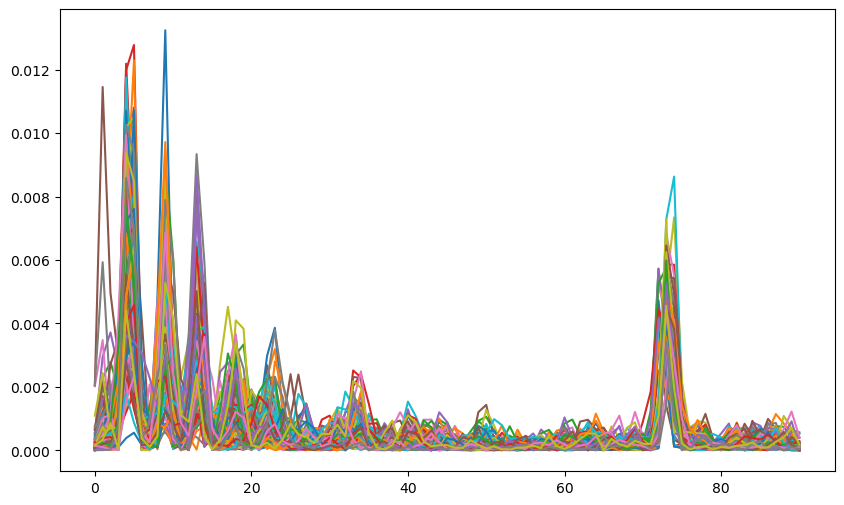

In [33]:
import matplotlib.pyplot as plt 
#Plot the spectrogram (frequency-time plot)
plt.figure(figsize=(10, 6))
for i in range(99):
    plt.plot(psds[i])


ValueError: Argument Z must be 2-dimensional.

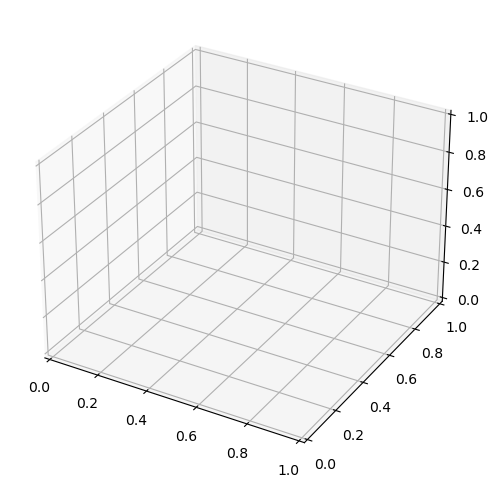

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'freqs' contains the frequency values for each segment
# Assuming 'psds' contains the power spectral density data for each segment

# Create a meshgrid of frequency and time
time, freq = np.meshgrid(np.arange(len(psds[0])), freq)

# Create a 3D figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
for i in range(99):
    ax.plot_surface(time, freq, psds[i], cmap='viridis', alpha=0.5)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Power Spectral Density')
plt.title('3D Spectrogram')

plt.show()


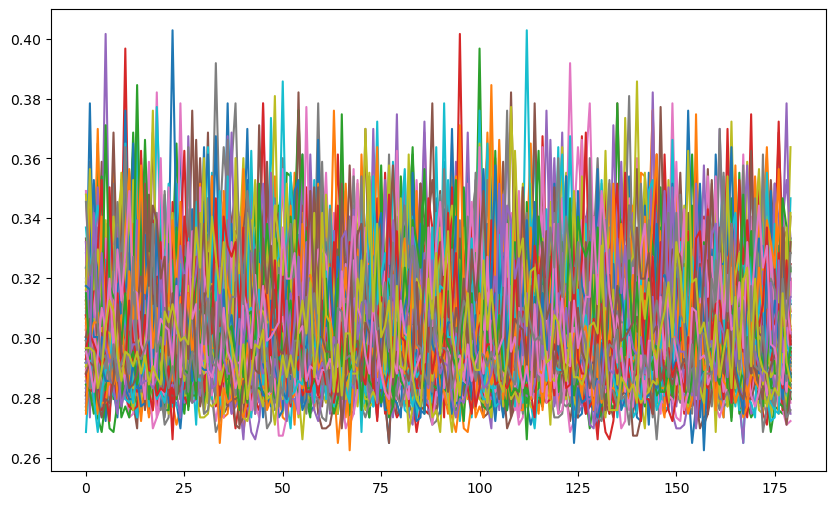

In [19]:
plt.figure(figsize=(10, 6))
for i in range(99):
    plt.plot(segments[i])

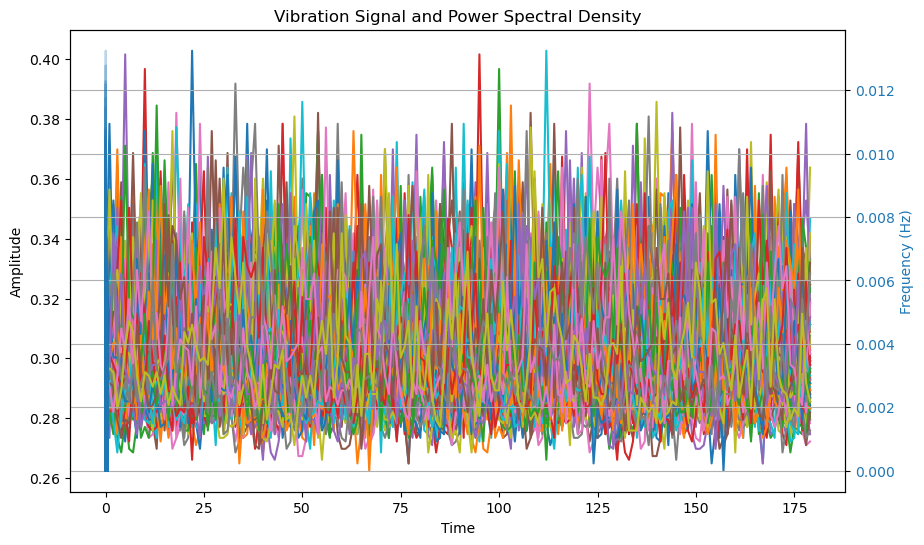

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'psds' contains the power spectral density data for each segment
# Assuming 'segments' contains the vibration signal segments
# Assuming 'freqs' contains the frequency values

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vibration signal segments
#color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
for i in range(99):
    ax1.plot(segments[i])  # Adjust color and transparency
ax1.tick_params(axis='y')

# Create another y-axis for frequency
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frequency (Hz)', color=color)
for i in range(99):
    ax2.plot(freq[i], psds[i], color=color, alpha=0.3)  # Adjust color and transparency
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vibration Signal and Power Spectral Density')
plt.grid(True)
plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'psds' contains the power spectral density data for each segment
# Assuming 'segments' contains the vibration signal segments
# Assuming 'freqs' contains the frequency values

# Create meshgrid for time and frequency dimensions
time, freq = np.meshgrid(np.arange(len(segments[0])), freq)

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the spectrogram
for i in range(99):
    ax.plot_surface(time, freq, psds[i].reshape(-1,1), cmap='viridis', alpha=0.5)  # Adjust colormap and transparency

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Power Spectral Density')
plt.title('3D Spectrogram')

plt.show()


MemoryError: Unable to allocate 99.0 GiB for an array with shape (147567420, 180) and data type int32